# Synthetic Data Generation for Imbalanced Classification: Results Analysis
 
### 1. Introduction
 
This notebook analyzes the experimental results comparing four synthetic data generation methods (CTGAN, TVAE, DDPM, NFlow) against a baseline classifier across varying levels of class imbalance in the Mammographic Mass dataset.

**Questions:**
1. At what imbalance ratios do synthetic methods significantly outperform the baseline?
2. Which generative model is most resilient to severe class imbalance?
3. What is the clinical impact of using these methods, particularly regarding the trade-off between precision and recall (sensitivity)?

**Experimental Design:**
- **Imbalance Ratios (IR):** 1:1, 5:1, 10:1, 20:1, 50:1, 100:1 (Benign:Malignant)
- **Generators:** CTGAN, TVAE, DDPM, NFlow (using naive oversampling of the minority class)
- **Baseline:** RandomForest trained on imbalanced data without augmentation
- **Control:** RandomForest trained on size-matched, balanced datasets
- **Evaluation Metrics:** F1-score (minority), ROC-AUC, Precision, Recall

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import glob
from matplotlib.patches import Patch
import re 

RESULTS_PATH = Path("../results/tables/")
FIGURES_PATH = Path("../results/figures/")
PROCESSED_PATH = Path("../data/processed/")
SYNTHETIC_PATH = Path("../data/synthetic/")

FIGURES_PATH.mkdir(exist_ok=True, parents=True)

MODELS_TO_ANALYZE = ['baseline', 'ctgan', 'tvae', 'ddpm', 'nflow']
SYNTHETIC_MODELS = ['ctgan', 'tvae', 'ddpm', 'nflow']

PALETTE = 'tab10'
MODEL_COLORS = {model: color for model, color in zip(MODELS_TO_ANALYZE, sns.color_palette(PALETTE, len(MODELS_TO_ANALYZE)))}

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100

print("Configuration loaded successfully!")
print(f"Models to analyze: {MODELS_TO_ANALYZE}")

Configuration loaded successfully!
Models to analyze: ['baseline', 'ctgan', 'tvae', 'ddpm', 'nflow']


In [2]:
try:
    summary_df = pd.read_csv(RESULTS_PATH / "summary_experiment_results.csv")
    detailed_df = pd.read_csv(RESULTS_PATH / "detailed_experiment_results.csv")
    print(" Results files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: Results files not found. Please run the experiment script first.")
    print(f"Expected files in: {RESULTS_PATH}")
    raise e

print(f"Total experimental conditions: {len(summary_df)}")
print(f"Total individual runs: {len(detailed_df)}")
print(f"\nDataset types: {summary_df['dataset_type'].unique()}")
print(f"Models tested: {summary_df['model'].unique()}")
print(f"Imbalance ratios: {sorted(summary_df['imbalance_ratio'].unique())}")

n_repetitions = detailed_df['repetition_id'].nunique()
print(f"Number of repetitions found: {n_repetitions}")


 Results files loaded successfully!
Total experimental conditions: 60
Total individual runs: 180

Dataset types: ['control' 'imbalanced']
Models tested: ['baseline' 'ctgan' 'ddpm' 'nflow' 'tvae']
Imbalance ratios: ['100:1', '10:1', '1:1', '20:1', '50:1', '5:1']
Number of repetitions found: 3


### 2. Data Preparation and Quality Check
 
We format the results DataFrame for consistent plotting and analysis.

In [3]:
def extract_ir_numeric(ir_str):
    return int(ir_str.split(':')[0])

summary_df['ir_numeric'] = summary_df['imbalance_ratio'].apply(extract_ir_numeric)
detailed_df['ir_numeric'] = detailed_df['imbalance_ratio'].apply(extract_ir_numeric)

summary_df = summary_df.sort_values(['dataset_type', 'ir_numeric', 'model'])
detailed_df = detailed_df.sort_values(['dataset_type', 'ir_numeric', 'model', 'repetition_id'])

print("\n Data Structure Check (first 10 rows) ")
print(summary_df[['dataset_type', 'imbalance_ratio', 'model', 'f1_minority_mean', 'f1_minority_std']].head(10))

print("\n Data Statistics ")
print(f"Models in summary: {summary_df['model'].unique()}")
print(f"IR values: {sorted(summary_df['ir_numeric'].unique())}")


 Data Structure Check (first 10 rows) 
   dataset_type imbalance_ratio     model  f1_minority_mean  f1_minority_std
10      control             1:1  baseline          0.799291         0.006681
11      control             1:1     ctgan          0.797226         0.005244
12      control             1:1      ddpm          0.790866         0.002412
13      control             1:1     nflow          0.800629         0.009883
14      control             1:1      tvae          0.792397         0.004302
25      control             5:1  baseline          0.784051         0.019504
26      control             5:1     ctgan          0.782008         0.018996
27      control             5:1      ddpm          0.791068         0.026921
28      control             5:1     nflow          0.771924         0.018948
29      control             5:1      tvae          0.793115         0.017612

 Data Statistics 
Models in summary: ['baseline' 'ctgan' 'ddpm' 'nflow' 'tvae']
IR values: [np.int64(1), np.int6

### 3. Overall Performance Comparison
 
Let's see how synthetic data methods perform compared to the baseline, visualizing the impact of multiple runs via standard deviation error bands.

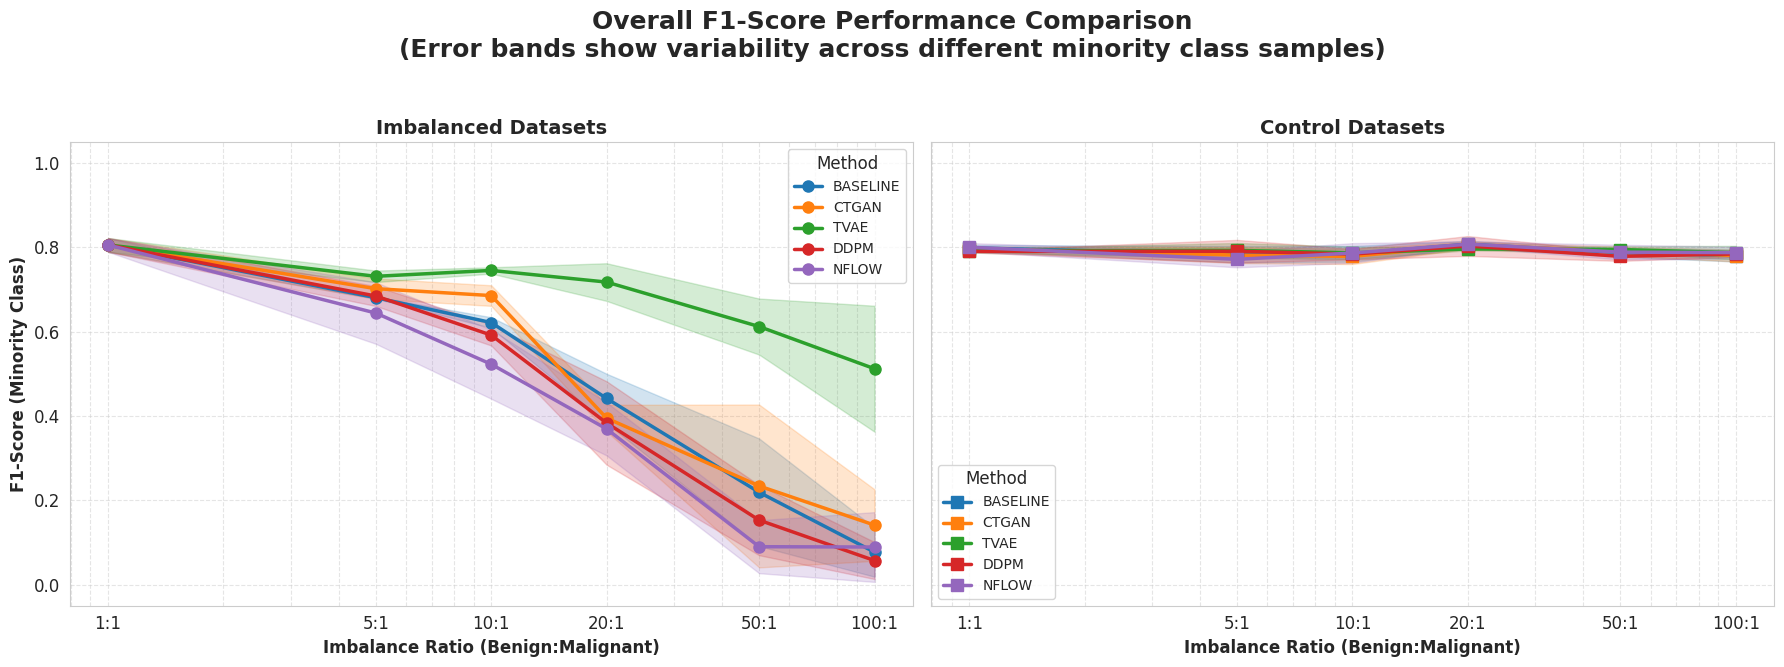

 Overall performance comparison plot saved


In [12]:

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.suptitle('Overall F1-Score Performance Comparison\n(Error bands show variability across different minority class samples)', 
             fontsize=18, fontweight='bold')

imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced']
control_data = summary_df[summary_df['dataset_type'] == 'control']

# Plot 1: Imbalanced datasets
ax = axes[0]
for model in MODELS_TO_ANALYZE:
    model_data = imbalanced_data[imbalanced_data['model'] == model]
    if model_data.empty: 
        continue
    
    ax.plot(model_data['ir_numeric'], model_data['f1_minority_mean'], 
            marker='o', linewidth=2.5, markersize=8, label=model.upper(), 
            color=MODEL_COLORS[model])
    
    # Add standard deviation bands
    std_dev = model_data['f1_minority_std'].fillna(0)
    ax.fill_between(model_data['ir_numeric'],
                    model_data['f1_minority_mean'] - std_dev,
                    model_data['f1_minority_mean'] + std_dev,
                    alpha=0.2, color=MODEL_COLORS[model])

ax.set_xlabel('Imbalance Ratio (Benign:Malignant)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score (Minority Class)', fontsize=12, fontweight='bold')
ax.set_title('Imbalanced Datasets', fontsize=14, fontweight='bold')
ax.legend(title='Method', fontsize=10)
ax.grid(True, which="both", linestyle='--', alpha=0.5)
ax.set_xscale('log')
ax.set_xticks([1, 5, 10, 20, 50, 100])
ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])
ax.set_ylim(-0.05, 1.05)


# Plot 2: Control datasets
ax = axes[1]
for model in MODELS_TO_ANALYZE:
    model_data = control_data[control_data['model'] == model]
    if model_data.empty: 
        continue
        
    ax.plot(model_data['ir_numeric'], model_data['f1_minority_mean'], 
            marker='s', linewidth=2.5, markersize=8, label=model.upper(), 
            color=MODEL_COLORS[model])
    
    std_dev = model_data['f1_minority_std'].fillna(0)
    ax.fill_between(model_data['ir_numeric'],
                    model_data['f1_minority_mean'] - std_dev,
                    model_data['f1_minority_mean'] + std_dev,
                    alpha=0.2, color=MODEL_COLORS[model])

ax.set_xlabel('Imbalance Ratio (Benign:Malignant)', fontsize=12, fontweight='bold')
ax.set_title('Control Datasets', fontsize=14, fontweight='bold')
ax.legend(title='Method', fontsize=10)
ax.grid(True, which="both", linestyle='--', alpha=0.5)
ax.set_xscale('log')
ax.set_xticks([1, 5, 10, 20, 50, 100])
ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FIGURES_PATH / 'overall_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Overall performance comparison plot saved")




### 4. Performance Degradation Analysis

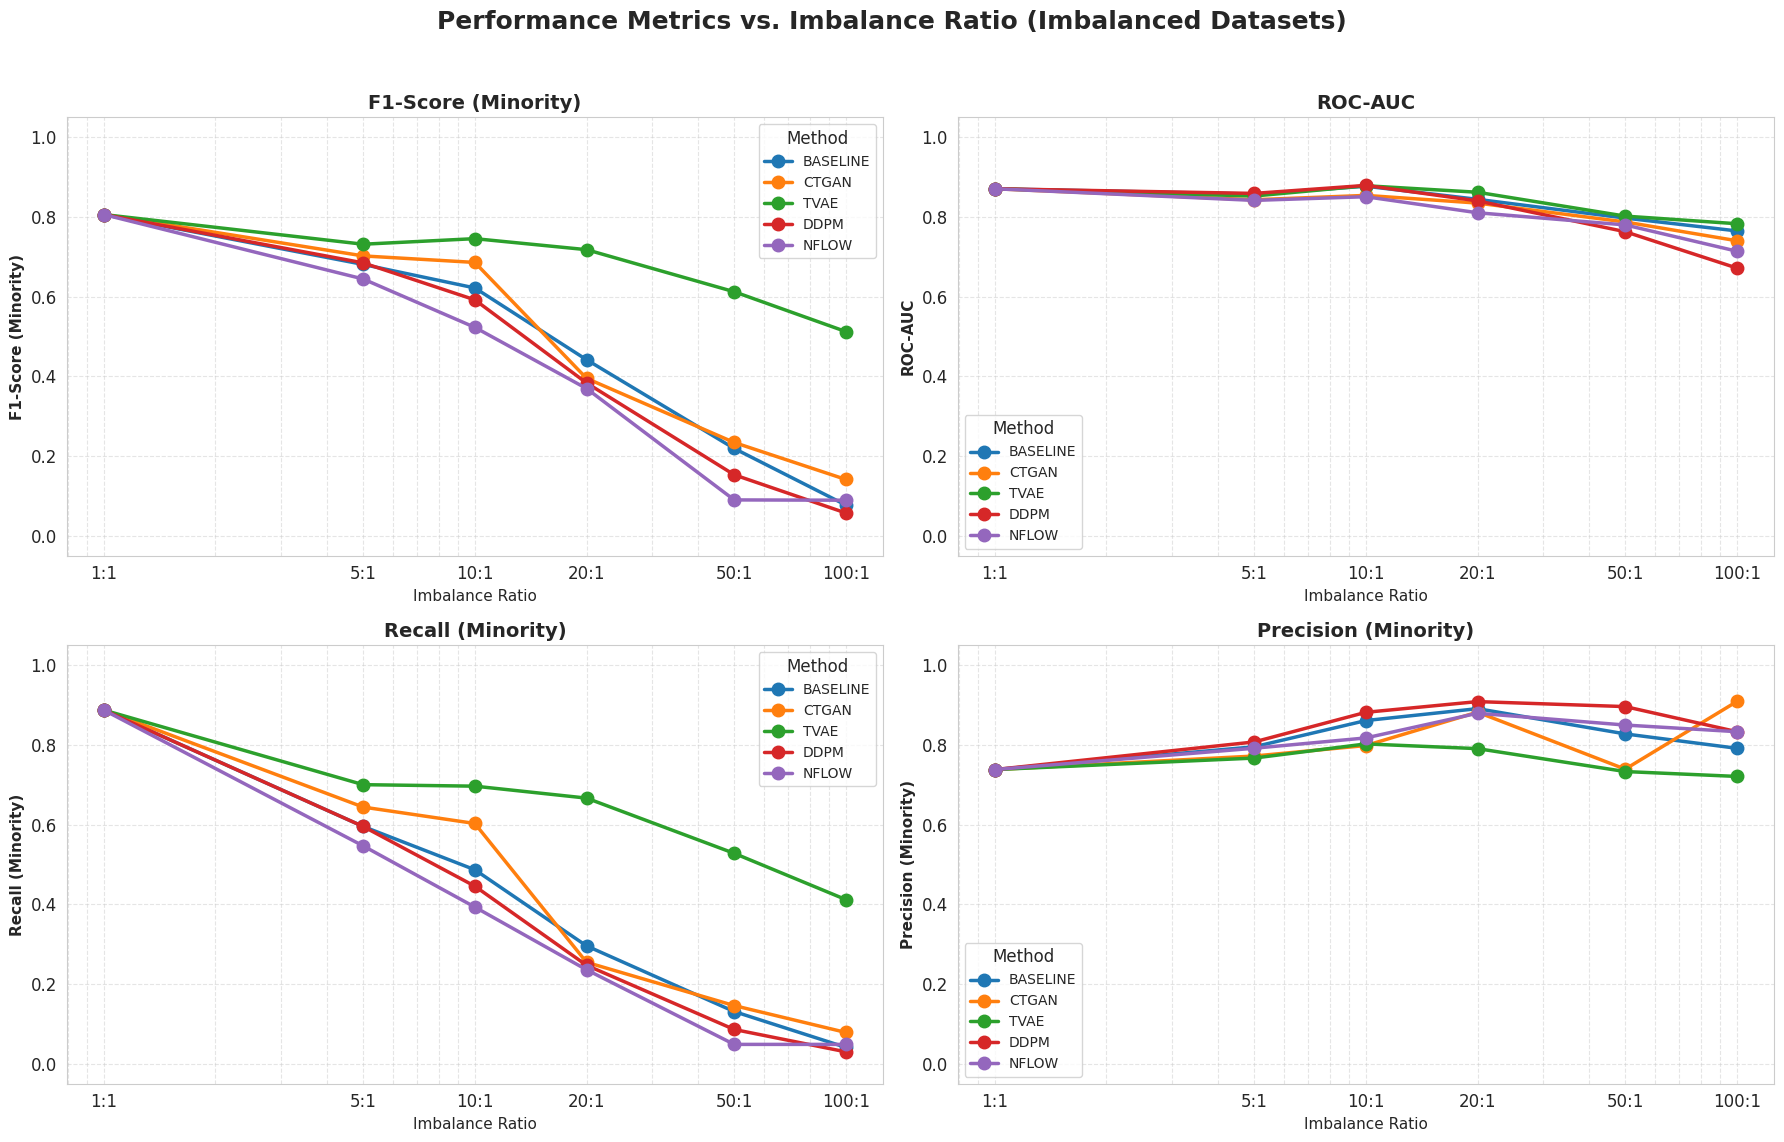

  Multi-metric performance analysis plot saved


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Performance Metrics vs. Imbalance Ratio (Imbalanced Datasets)', 
             fontsize=18, fontweight='bold')

metrics = ['f1_minority_mean', 'roc_auc_mean', 'recall_minority_mean', 'precision_minority_mean']
titles = ['F1-Score (Minority)', 'ROC-AUC', 'Recall (Minority)', 'Precision (Minority)']

imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    for model in MODELS_TO_ANALYZE:
        model_data = imbalanced_data[imbalanced_data['model'] == model]
        if model_data.empty: 
            continue
        
        ax.plot(model_data['ir_numeric'], model_data[metric], 
                marker='o', linewidth=2.5, markersize=9, label=model.upper(), 
                color=MODEL_COLORS[model])
    
    ax.set_xscale('log')
    ax.set_xlabel('Imbalance Ratio', fontsize=11)
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(title='Method', fontsize=10)
    ax.grid(True, which="both", linestyle='--', alpha=0.5)
    ax.set_xticks([1, 5, 10, 20, 50, 100])
    ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(FIGURES_PATH / 'all_metrics_by_imbalance.png', dpi=300, bbox_inches='tight')
plt.show()

### 5. Relative Performance Improvement
 
Here, we calculate the percentage improvement of each synthetic method over the baseline for each imbalance ratio. This highlights where synthetic data provides the most value.

In [7]:
imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced'].copy()

improvement_data = []
for ir in sorted(imbalanced_data['ir_numeric'].unique()):
    ir_data = imbalanced_data[imbalanced_data['ir_numeric'] == ir]
    baseline_f1 = ir_data[ir_data['model'] == 'baseline']['f1_minority_mean'].values[0]

    for model in SYNTHETIC_MODELS:
        model_f1_series = ir_data[ir_data['model'] == model]['f1_minority_mean']
        if model_f1_series.empty: 
            continue
        
        model_f1 = model_f1_series.values[0]
        improvement = ((model_f1 - baseline_f1) / baseline_f1) * 100 if baseline_f1 > 1e-6 else 0
        
        improvement_data.append({
            'ir_numeric': ir, 
            'model': model, 
            'improvement_pct': improvement
        })

improvement_df = pd.DataFrame(improvement_data)

print("  Improvement Statistics  ")
print(improvement_df.groupby('model')['improvement_pct'].describe())

  Improvement Statistics  
       count        mean         std        min        25%        50%  \
model                                                                   
ctgan    6.0   15.497684   33.974972 -10.577824   0.784255   4.987275   
ddpm     6.0  -12.226115   13.228011 -30.141365 -22.651630  -8.994843   
nflow    6.0  -13.455717   25.235820 -58.915791 -16.249362 -10.632967   
tvae     6.0  138.970633  218.814705   0.000000  10.556248  41.188299   

              75%         max  
model                          
ctgan    9.429918   83.295333  
ddpm    -1.197799    0.577038  
nflow   -1.340837   15.812374  
tvae   150.209799  564.551337  


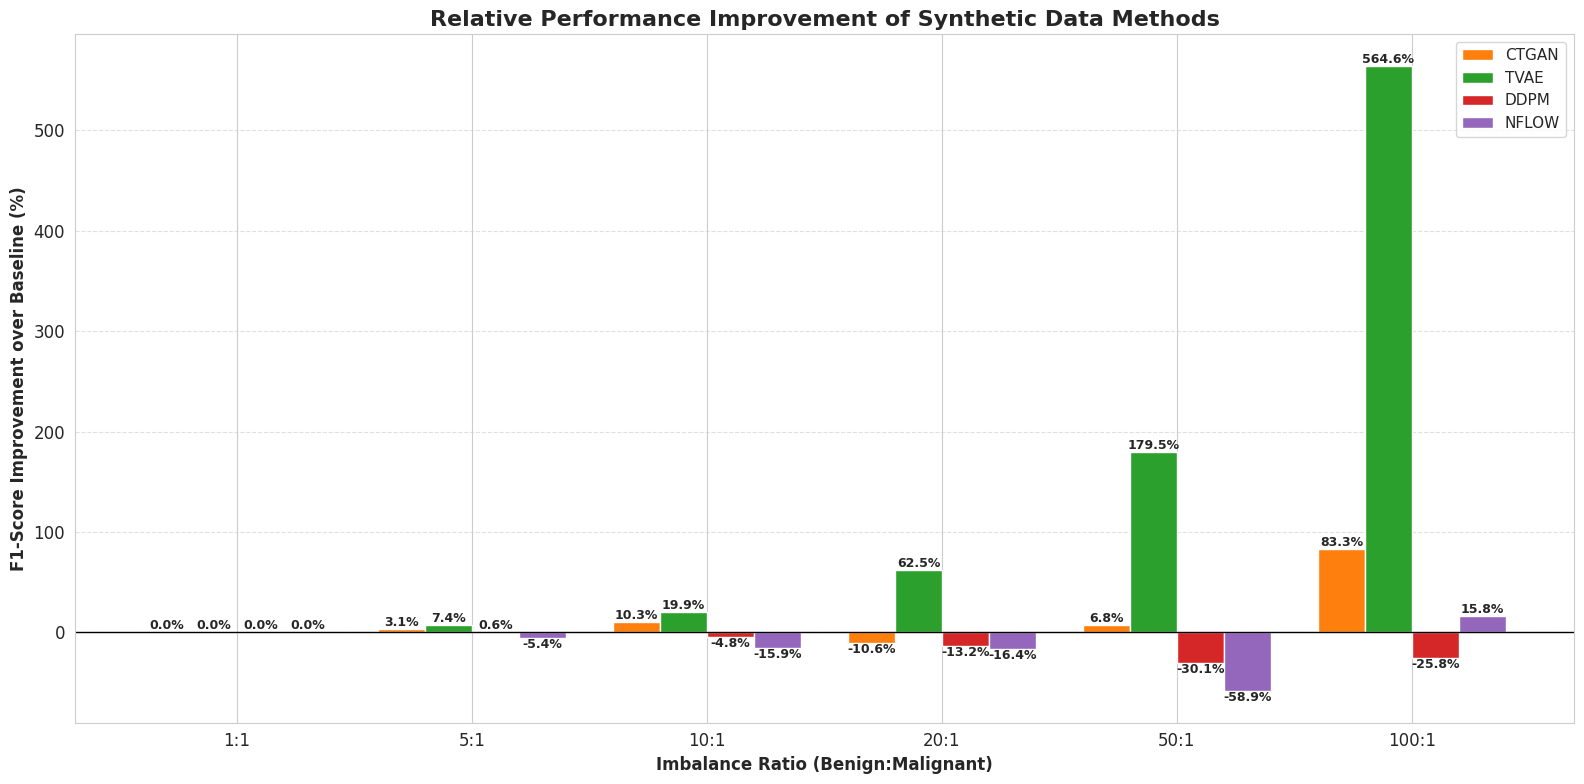

  Improvement over baseline plot saved


In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
n_generators = len(SYNTHETIC_MODELS)
x = np.arange(len(improvement_df['ir_numeric'].unique()))
width = 0.8 / n_generators
x_labels = [f'{ir}:1' for ir in sorted(improvement_df['ir_numeric'].unique())]

for i, model in enumerate(SYNTHETIC_MODELS):
    model_data = improvement_df[improvement_df['model'] == model]
    offset = width * (i - (n_generators - 1) / 2)
    bars = ax.bar(x + offset, model_data['improvement_pct'], width, 
                   label=model.upper(), color=MODEL_COLORS[model])

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.1f}%',
                ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=9, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Imbalance Ratio (Benign:Malignant)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score Improvement over Baseline (%)', fontsize=12, fontweight='bold')
ax.set_title('Relative Performance Improvement of Synthetic Data Methods', 
             fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'improvement_over_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

### 6. Precision-Recall Trade-off Analysis

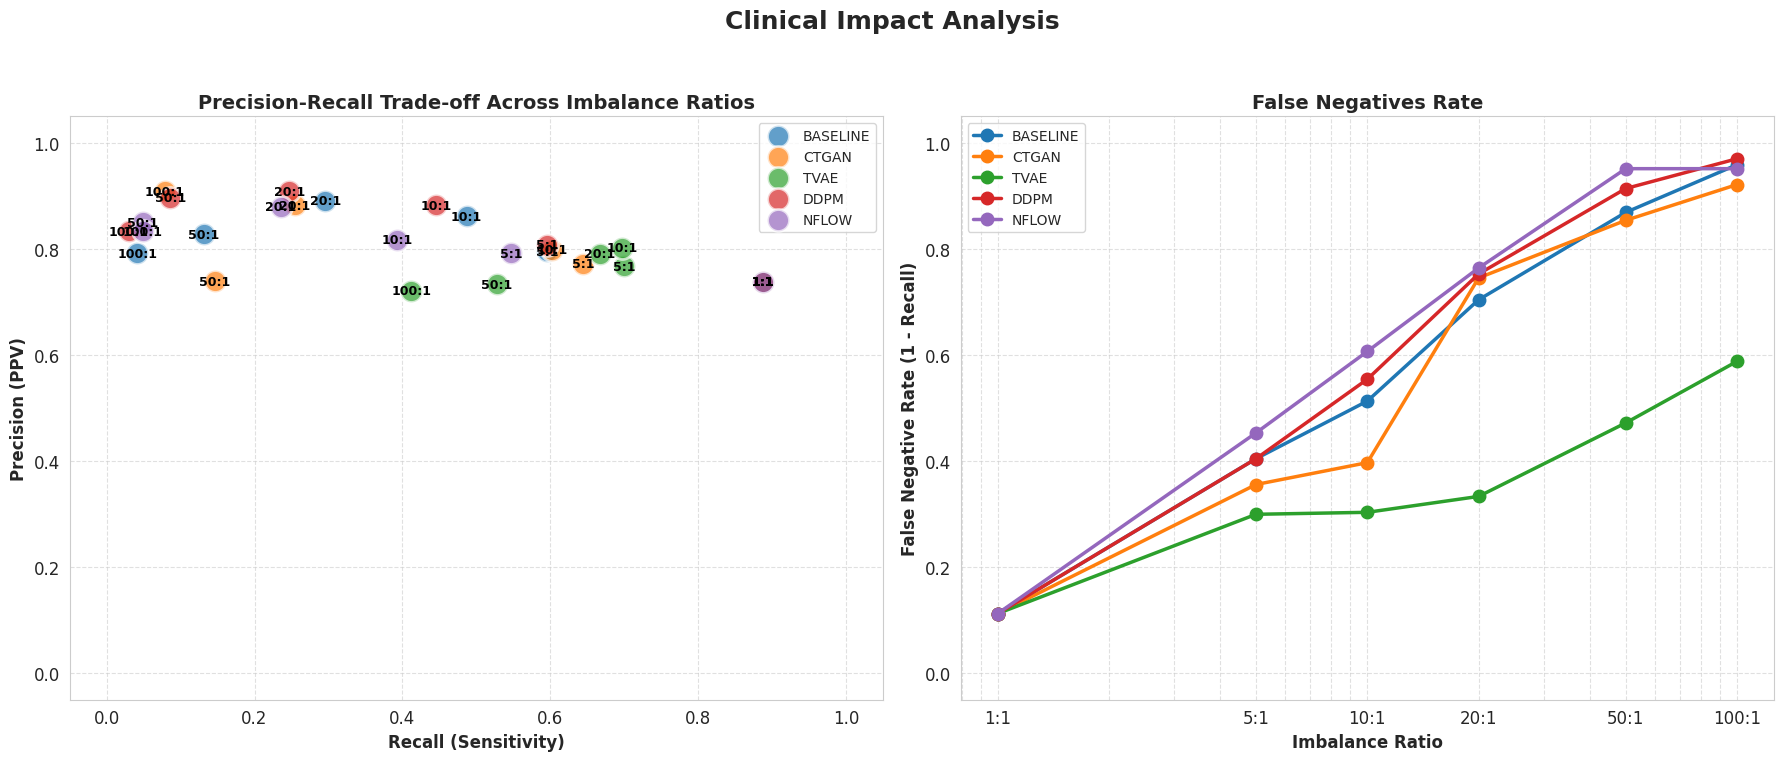

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Clinical Impact Analysis', fontsize=18, fontweight='bold')
imbalanced_data = summary_df[summary_df['dataset_type'] == 'imbalanced']

# Plot 1: Precision vs Recall scatter
ax = axes[0]
for model in MODELS_TO_ANALYZE:
    model_data = imbalanced_data[imbalanced_data['model'] == model]
    if model_data.empty: 
        continue
    
    ax.scatter(model_data['recall_minority_mean'], model_data['precision_minority_mean'],
               s=250, alpha=0.7, label=model.upper(), color=MODEL_COLORS[model], 
               edgecolors='w', linewidth=2)
    
    for _, row in model_data.iterrows():
        ax.annotate(f"{row['ir_numeric']}:1", 
                    (row['recall_minority_mean'], row['precision_minority_mean']),
                    fontsize=9, ha='center', va='center', color='black', weight='bold')

ax.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision (PPV)', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Trade-off Across Imbalance Ratios', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# Plot 2: False Negative Rate 
ax = axes[1]
for model in MODELS_TO_ANALYZE:
    model_data = imbalanced_data[imbalanced_data['model'] == model]
    if model_data.empty: 
        continue
    
    fnr = 1 - model_data['recall_minority_mean']
    ax.plot(model_data['ir_numeric'], fnr, marker='o', linewidth=2.5, markersize=9, 
            label=f'{model.upper()}', color=MODEL_COLORS[model])

ax.set_xscale('log')
ax.set_xlabel('Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('False Negative Rate (1 - Recall)', fontsize=12, fontweight='bold')
ax.set_title('False Negatives Rate', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle='--', alpha=0.6)
ax.set_xticks([1, 5, 10, 20, 50, 100])
ax.set_xticklabels(['1:1', '5:1', '10:1', '20:1', '50:1', '100:1'])
ax.set_ylim(-0.05, 1.05)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FIGURES_PATH / 'precision_recall_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 7. Synthetic Dataset Imbalance Ratio Validation
 
Do the generative models successfully balance the training data as intended? This analysis checks the class distribution of the final training datasets.

In [10]:
def analyze_imbalance_ratio(df, target_col='Severity'):
    value_counts = df[target_col].value_counts()
    if len(value_counts) < 2 or value_counts.min() == 0: 
        return {
            'imbalance_ratio': float('inf'), 
            'n_majority': value_counts.max() if len(value_counts) > 0 else len(df), 
            'n_minority': 0
        }
    
    majority = value_counts.max()
    minority = value_counts.min()
    return {
        'imbalance_ratio': round(majority / minority, 2) if minority > 0 else float('inf'),
        'n_majority': int(majority), 
        'n_minority': int(minority)
    }

ir_analysis_results = []

original_train_files = sorted(glob.glob(str(PROCESSED_PATH / "train_imbalanced_ir_*_rep*.csv")))
print(f"Found {len(original_train_files)} original training files")

for original_file in original_train_files:
    original_path = Path(original_file)
    original_df = pd.read_csv(original_path)
    
    match = re.search(r'ir_(\d+)_rep(\d+)', original_path.name)
    if not match:
        continue
    ir_value, rep_id = map(int, match.groups())

    original_analysis = analyze_imbalance_ratio(original_df)

    for generator in SYNTHETIC_MODELS:
        synth_filename = f"{original_path.stem}_balanced_by_{generator}.csv"
        synth_path = SYNTHETIC_PATH / synth_filename
        
        if not synth_path.exists(): 
            continue
        
        synthetic_df = pd.read_csv(synth_path)
        synthetic_analysis = analyze_imbalance_ratio(synthetic_df)
        
        entry = {
            'original_ir': ir_value,
            'generator': generator,
            'run': rep_id,
            'original_n_maj': original_analysis['n_majority'],
            'original_n_min': original_analysis['n_minority'],
            'final_n_maj': synthetic_analysis['n_majority'],
            'final_n_min': synthetic_analysis['n_minority'],
            'achieved_ir': synthetic_analysis['imbalance_ratio']
        }
        ir_analysis_results.append(entry)

if ir_analysis_results:
    ir_comparison_df = pd.DataFrame(ir_analysis_results)
    ir_summary_df = ir_comparison_df.groupby(['original_ir', 'generator']).agg(
        mean_final_n_maj=('final_n_maj', 'mean'),
        mean_final_n_min=('final_n_min', 'mean'),
        mean_achieved_ir=('achieved_ir', 'mean'),
        std_achieved_ir=('achieved_ir', 'std')
    ).reset_index()
else:
    print("\nWARNING: No synthetic data files were found. Plots will be empty.")
    ir_summary_df = pd.DataFrame(columns=['original_ir', 'generator', 'mean_final_n_maj', 
                                          'mean_final_n_min', 'mean_achieved_ir', 'std_achieved_ir'])

print("\n  Imbalance Ratio Validation Summary  ")
print(ir_summary_df)

Found 18 original training files

  Imbalance Ratio Validation Summary  
    original_ir generator  mean_final_n_maj  mean_final_n_min  \
0             5     ctgan        428.000000        396.000000   
1             5      ddpm        677.666667        146.333333   
2             5     nflow        692.666667        131.333333   
3             5      tvae        412.000000        412.000000   
4            10     ctgan        444.666667        379.333333   
5            10      ddpm        745.333333         78.666667   
6            10     nflow        745.333333         78.666667   
7            10      tvae        412.666667        411.333333   
8            20     ctgan        749.333333         74.666667   
9            20      ddpm        789.333333         34.666667   
10           20     nflow        793.666667         30.333333   
11           20      tvae        414.666667        409.333333   
12           50     ctgan        796.333333         27.666667   
13           50  

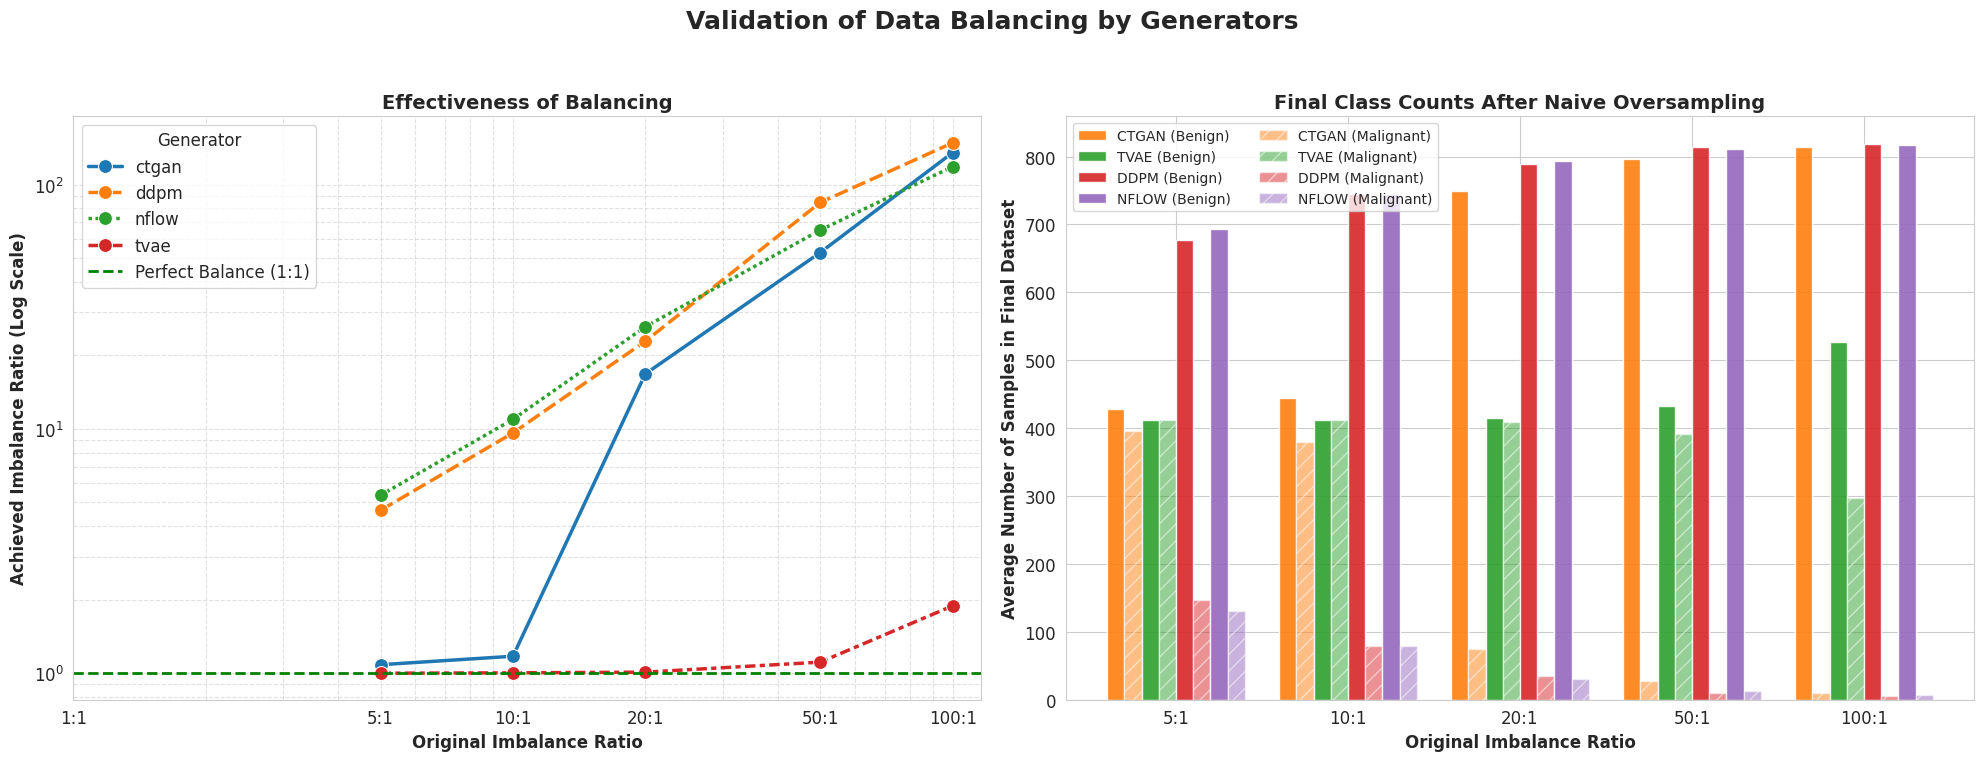

  Balancing validation plot saved


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Validation of Data Balancing by Generators', fontsize=18, fontweight='bold')

#   Plot 1: Achieved Imbalance Ratio  
ax = axes[0]
sns.lineplot(data=ir_summary_df, x='original_ir', y='mean_achieved_ir', 
             hue='generator', style='generator', 
             ax=ax, marker='o', markersize=10, linewidth=2.5, palette=PALETTE)
ax.axhline(y=1, color='green', linestyle='--', linewidth=2, label='Perfect Balance (1:1)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Original Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('Achieved Imbalance Ratio (Log Scale)', fontsize=12, fontweight='bold')
ax.set_title('Effectiveness of Balancing', fontsize=14, fontweight='bold')
ax.set_xticks([1, 5, 10, 20, 50, 100])
ax.set_xticklabels([f'{ir}:1' for ir in [1, 5, 10, 20, 50, 100]])
ax.legend(title='Generator')
ax.grid(True, which="both", linestyle='--', alpha=0.6)

#   Plot 2: Final Class Counts  
ax = axes[1]
n_irs = len(ir_summary_df['original_ir'].unique())
n_gens = len(SYNTHETIC_MODELS)
x = np.arange(n_irs)
width = 0.8 / n_gens
x_labels = [f'{ir}:1' for ir in sorted(ir_summary_df['original_ir'].unique())]

for i, generator in enumerate(SYNTHETIC_MODELS):
    gen_data = ir_summary_df[ir_summary_df['generator'] == generator]
    offset = width * (i - (n_gens - 1) / 2)
    
    # Benign (majority) bars
    ax.bar(x + offset - width/4, gen_data['mean_final_n_maj'], width/2, 
           label=f'{generator.upper()} (Benign)', 
           color=MODEL_COLORS[generator], alpha=0.9)
    
    # Malignant (minority) bars
    ax.bar(x + offset + width/4, gen_data['mean_final_n_min'], width/2, 
           label=f'{generator.upper()} (Malignant)', 
           color=MODEL_COLORS[generator], alpha=0.5, hatch='//')

ax.set_xlabel('Original Imbalance Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Number of Samples in Final Dataset', fontsize=12, fontweight='bold')
ax.set_title('Final Class Counts After Naive Oversampling', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

legend_elements = [
    Patch(facecolor=MODEL_COLORS[gen], label=f'{gen.upper()} (Benign)', alpha=0.9) 
    for gen in SYNTHETIC_MODELS
] + [
    Patch(facecolor=MODEL_COLORS[gen], label=f'{gen.upper()} (Malignant)', alpha=0.5, hatch='//') 
    for gen in SYNTHETIC_MODELS
]
ax.legend(handles=legend_elements, ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FIGURES_PATH / 'imbalance_ratio_validation.png', dpi=300, bbox_inches='tight')
plt.show()